In [1]:
from diffusers import UNet2DConditionModel, UNet2DModel, DDPMPipeline#, #DDPMScheduler
from model import DDPMScheduler
import torch
from PIL import Image
import numpy as np
import os
os.chdir("/workspace")
from data import MVTecAD,create_dataloader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_set = MVTecAD(
    datadir='./dataset/mvtec_ad',
    target='capsule',
    train=True,
    img_size=256,
    self_aug='self-augmentation',
    normalize=False
)
test_dataloader = create_dataloader(data_set, is_training=True, batch_size=2, num_workers=1)

In [21]:
anomaly_indices = list(range(len(data_set.file_list) // 2))
non_anomaly_indices = list(range(len(data_set.file_list) // 2, len(data_set.file_list)))


In [23]:
non_anomaly_indices

[109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218]

In [3]:
test_img, test_mask, test_label = next(iter(test_dataloader))

/usr/local/lib/python3.10/site-packages/imgaug/augmenters/base.py:27: SuspiciousMultiImageShapeWarning: You provided a numpy array of shape (256, 256, 3) as a multi-image augmentation input, which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use e.g. augmenter(image=<your input>) or augment_image(<your input>) -- note the singular 'image' instead of 'imageS'. Otherwise your single input image will be interpreted as multiple images of shape (H, W) during augmentation.
  ia.warn(


In [4]:
model = UNet2DModel(
    sample_size=(256,256),
    in_channels=3,
    out_channels=3,
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    block_out_channels=(128, 256, 512, 1024, 2048),
    attention_head_dim= 4
)
ddpm_scheduler = DDPMScheduler(
    num_train_timesteps= 1000,
    beta_schedule='linear',
    prediction_type='epsilon')
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(12

In [5]:
# print the feature size of each layer
#result = model(test_img.to(device), timestep = torch.randint(100, 200, (test_img.shape[0],)).to(device))

In [6]:
#result.sample.shape

torch.Size([2, 3, 256, 256])

In [7]:
original_samples = data_set[0][0].unsqueeze(0).to(device)
timesteps = torch.randint(100, 200, (1,)).to(device)
noise = torch.randn_like(original_samples).to(device)
noisy_sample = scheduler.add_noise(original_samples, noise, timesteps)
print(timesteps.item())

195


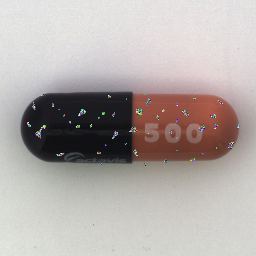

In [8]:
Image.fromarray((original_samples.detach().cpu()[0].permute(1,2,0).numpy()*255).astype(np.uint8))

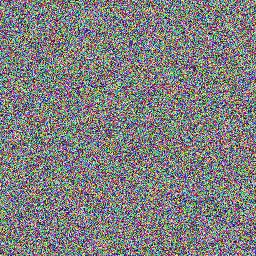

In [9]:
Image.fromarray((noisy_sample.detach().cpu()[0].permute(1,2,0).numpy()*255).astype(np.uint8))

In [18]:
# making a gif maker function (timestep: 0~1000)
import imageio
def make_gif(scheduler, original_samples, max_timesteps, term, save_path):
    images =[]
    for i in range(0, max_timesteps, term):
        timesteps = torch.tensor(i, dtype=torch.int32).to(device)
        noise = torch.randn_like(original_samples).to(device)
        noisy_sample = scheduler.add_noise(original_samples, noise, timesteps)
        noisy_sample = noisy_sample.detach().cpu()[0].permute(1,2,0).numpy()*255
        noisy_sample = noisy_sample.astype(np.uint8)
        images.append(noisy_sample)
        Image.fromarray(noisy_sample).save(save_path+f"/{i}.png")
    # save as gif
    imageio.mimsave(save_path+f"/{i}.gif", images, duration=20)



In [20]:
make_gif(scheduler, original_samples, 1000, 10, "./src")

In [6]:
test_img.device

device(type='cpu')

In [5]:
#original_samples = data_set[0][0].unsqueeze(0).to(device)
test_img = test_img.to(device)
timesteps = torch.randint(100, 200, (test_img.shape[0],)).to(device)
noise = torch.randn_like(test_img).to(device)
noisy_sample = ddpm_scheduler.add_noise(test_img, noise, timesteps)
model_output = model(noisy_sample, timesteps).sample

In [6]:
generator = torch.manual_seed(0)

In [8]:
predict_image = ddpm_scheduler.step(
                model_output= model_output.to("cpu"),
                timestep = timesteps.to("cpu"),
                sample =  noisy_sample.to("cpu"),
                generator=generator).prev_sample

In [7]:
predict_image = ddpm_scheduler.step(
                model_output= model_output,
                timestep = timesteps,
                sample =  noisy_sample,
                generator=generator).prev_sample

In [8]:
x_hat = ddpm_scheduler.onestep_denoise(
    original_samples=test_img,
    noise = noise,
    timesteps = timesteps,
    model_output=model_output,
)

In [9]:
x_hat.shape

torch.Size([2, 3, 256, 256])

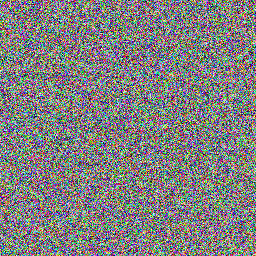

In [19]:
Image.fromarray((x_hat.detach().cpu()[0].permute(1,2,0).numpy()*255).astype(np.uint8))

In [17]:
(x_hat.detach().cpu()[0].permute(1,2,0).numpy()*255).astype(np.uint8).shape

(256, 256, 3)

In [13]:
test_img.shape

torch.Size([2, 3, 256, 256])

In [14]:
noisy_sample.shape

torch.Size([2, 3, 256, 256])

In [12]:
model_output.shape

torch.Size([2, 3, 256, 256])

In [18]:
timesteps.shape

torch.Size([2])

In [23]:
ddpm_scheduler.alphas_cumprod.shape

torch.Size([1000])

In [29]:
(1- ddpm_scheduler.alphas_cumprod[timesteps.to("cpu")])

tensor([0.3329, 0.1996])

In [30]:
(1- ddpm_scheduler.alphas_cumprod[timesteps.to("cpu")])**0.5

tensor([0.5770, 0.4468])

In [40]:
noisy_sample.to("cpu") - torch.sqrt(1- ddpm_scheduler.alphas_cumprod[timesteps.to("cpu")])[:,None,None,None]*model_output.to("cpu")

tensor([[[[ 5.6866e-01, -4.9771e-01,  2.0808e+00,  ...,  1.2304e+00,
            1.8735e-02,  4.2972e-01],
          [ 1.3183e+00,  4.3451e-01,  6.8323e-01,  ...,  3.7653e-01,
            1.4833e+00,  7.2526e-01],
          [ 8.6631e-01,  1.1540e+00,  4.3165e-01,  ...,  9.6823e-01,
            1.2725e+00, -2.9363e-01],
          ...,
          [ 6.5076e-01,  1.3470e+00,  7.3669e-01,  ...,  1.6803e-01,
            1.1937e-01,  2.1075e-01],
          [ 1.2022e-01,  1.8815e+00,  1.2872e+00,  ..., -4.8775e-01,
            2.5467e-01,  4.0010e-01],
          [ 1.5357e+00,  3.2921e-01,  2.5876e-01,  ...,  3.9010e-01,
            1.4280e+00,  9.2717e-01]],

         [[ 8.7740e-01,  2.0059e+00,  7.0481e-01,  ...,  8.7665e-01,
            4.6719e-01,  8.9071e-01],
          [ 1.1745e+00,  1.0410e+00,  4.7572e-01,  ...,  8.2236e-01,
            3.7191e-01, -1.4793e-01],
          [ 7.1618e-01,  8.2878e-01, -9.1936e-02,  ..., -1.5206e-01,
            7.1840e-01,  7.3473e-01],
          ...,
     

In [10]:
pred_original_sample = (
                noisy_sample.to("cpu")
                - beta_prod_t ** (0.5) * model_output.to("cpu")
            ) / alpha_prod_t ** (0.5)
pred_original_sample_coeff = (
            alpha_prod_t_prev ** (0.5) * current_beta_t
        ) / beta_prod_t

In [11]:
current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

In [12]:
pred_original_sample.shape, pred_original_sample_coeff.shape, current_sample_coeff.shape

(torch.Size([2, 3, 256, 256]),
 torch.Size([2, 1, 1, 1]),
 torch.Size([2, 1, 1, 1]))

In [13]:
pred_prev_sample = (
            pred_original_sample_coeff * pred_original_sample
            + current_sample_coeff * noisy_sample.to("cpu")
        )

In [14]:
from diffusers.utils import BaseOutput, randn_tensor

variance_noise = randn_tensor(
            model_output.shape,
            generator=generator,
            device=device,
            dtype=model_output.dtype,
        )

In [15]:
ddpm_scheduler.variance_type

'fixed_small'

In [16]:
predicted_variance = None

In [18]:
variance = (ddpm_scheduler._get_variance(timesteps.to("cpu"), predicted_variance=predicted_variance) ** 0.5) * variance_noise.to("cpu")